In [163]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
np.random.seed(42)

## Homework Reflection 9

### Question 1

1. Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity.  
Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.

Simulated SE (true): 0.0571
Average OLS SE: 0.0567
Average Robust SE: 0.0571


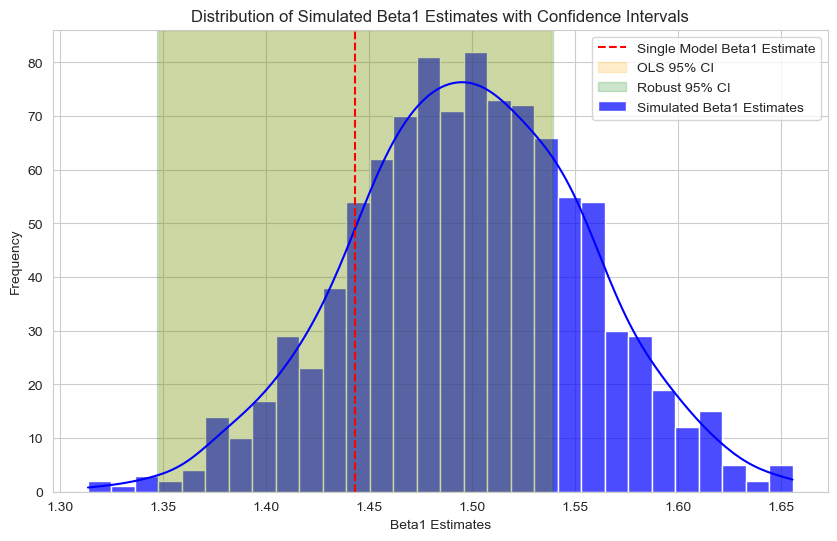

In [164]:
# Simulate a regression with heteroscedastic errors
def simulate_regression(n_samples=100, n_simulations = 1000, true_beta0 = 2.0, true_beta1 = 1.5):

    # storage for coefficients
    beta0_estimates = []
    beta1_estimates = []
    ols_se_beta1 = []
    robust_se_beta1 = []

    for sim in range(n_simulations):
        # generate x values
        X = np.random.uniform(1, 10, n_samples)
        # create heterosketastic error variance (increases linearly with x)
        sigma_squared = 0.5 + 0.3 * X
        # generate errors
        errors = np.random.normal(0, np.sqrt(sigma_squared)) 
        # y values
        Y = true_beta0 + true_beta1 * X + errors
        # ols estimation using statsmodels
        X_with_constant = sm.add_constant(X)
        model = sm.OLS(Y, X_with_constant).fit()

        # calculate estimates and standard errors
        beta0_estimates.append(model.params[0])
        beta1_estimates.append(model.params[1])
        ols_se_beta1.append(model.bse[1])
        
        # calculate robust standard errors
        robust_se = model.get_robustcov_results(cov_type='HC3')
        robust_se_beta1.append(robust_se.bse[1])
    
    return {
            'beta0_estimates': beta0_estimates,
            'beta1_estimates': beta1_estimates,
            'ols_se_beta1': ols_se_beta1,
            'robust_se_beta1': robust_se_beta1
        }


# generate a single dataset
n_samples = 100
X = np.random.uniform(1, 10, 100)
sigma_squared = 0.5 + 0.3 * X
errors = np.random.normal(0, np.sqrt(sigma_squared))
Y = 2.0 + 1.5 * X + errors

# fit single ols model
X_with_constant = sm.add_constant(X)
single_model = sm.OLS(Y, X_with_constant).fit()
single_robust = single_model.get_robustcov_results(cov_type='HC3')

# collect results from single model
single_results = {
    'beta0': single_model.params[0],
    'beta1': single_model.params[1],
    'ols_se_beta1': single_model.bse[1],
    'robust_se_beta1': single_robust.bse[1]
}

# run our simulation and single model
simulation_results = simulate_regression(n_samples=n_samples, n_simulations=1000)
results_df = pd.DataFrame(simulation_results)

# Simulated standard deviation (the "true" standard error)
simulated_se_beta1 = np.std(results_df['beta1_estimates'])

# Average OLS standard error from statsmodels
avg_ols_se = np.mean(results_df['ols_se_beta1'])

# Average robust standard error
avg_robust_se = np.mean(results_df['robust_se_beta1'])

print(f"Simulated SE (true): {simulated_se_beta1:.4f}")
print(f"Average OLS SE: {avg_ols_se:.4f}")
print(f"Average Robust SE: {avg_robust_se:.4f}")

# plot histogram of simulated beta1 estimates with single model overlaid
plt.figure(figsize=(10, 6))
sns.histplot(results_df['beta1_estimates'], bins=30, kde=True, color='blue', alpha=0.7, label='Simulated Beta1 Estimates')

# Add vertical line for single model estimate
plt.axvline(single_results['beta1'], color='red', linestyle='--', label='Single Model Beta1 Estimate')

# Add confidence intervals using standard errors
# OLS confidence interval (will be too narrow under heteroskedasticity)
ols_lower = single_results['beta1'] - 1.96 * single_results['ols_se_beta1']
ols_upper = single_results['beta1'] + 1.96 * single_results['ols_se_beta1']
plt.axvspan(ols_lower, ols_upper, alpha=0.2, color='orange', label='OLS 95% CI')

# Robust confidence interval
robust_lower = single_results['beta1'] - 1.96 * single_results['robust_se_beta1']
robust_upper = single_results['beta1'] + 1.96 * single_results['robust_se_beta1']
plt.axvspan(robust_lower, robust_upper, alpha=0.2, color='green', label='Robust 95% CI')

plt.title('Distribution of Simulated Beta1 Estimates with Confidence Intervals')
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Q1 Analysis:
The above code simulates the "true" sampling distribution created using a montecarlo simulation, then compares the "true" distribution to the standard and robust standard error calculations found using stats models ols. 
- The chart compares the true distribution with the 95% CI estimate from the OLS model. 
- The big comparison point that I'm trying to show here is that the simulation shows the true sampling distribution, whereas a single model gives you one $\beta_1$ estimate that should approximate, but ultimately underestimates the simulations actual standard deviation.
- The Robust 95% CI gets closer to the true distribution. 

### Question 2

2. Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent.
Compare these standard errors to those found via statsmodels OlS or a similar linear regression model.

Autocorrelation Simulation Results:
__________________________________________________
Auto Correlation coefficient: 0.7
Mean_beta_1: 1.4967 vs true beta_1: 1.5
Actual Standard Deviation of Beta1: 0.0529
Average OLS Standard Error of Beta1: 0.0526
Average HAC Standard Error of Beta1: 0.0497
__________________________________________________
Single Model Results:
__________________________________________________
Single Model Beta1 Estimate: 1.5129
Single Model OLS Standard Error of Beta1: 0.0402
Single Model HAC Standard Error of Beta1: 0.0353


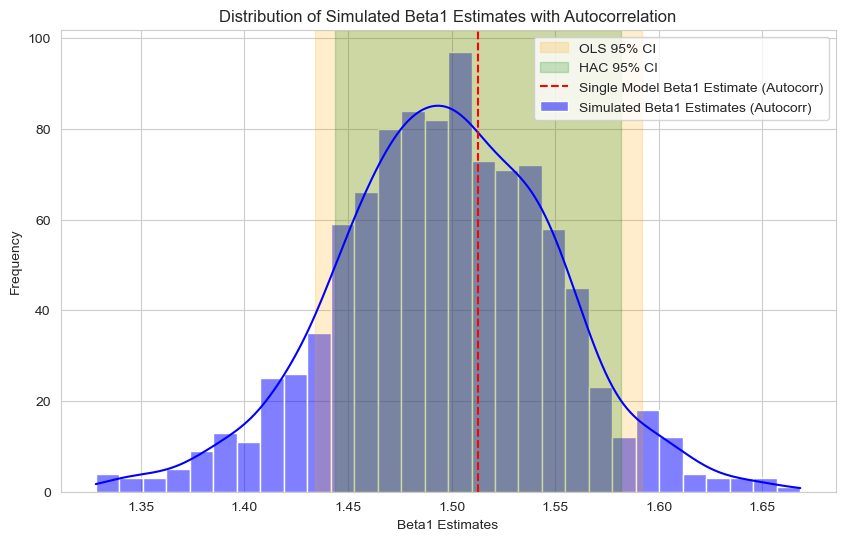

In [165]:
# Simulate a regression with autocorrelated errors
def simulate_regression_autocorr(n_samples=100, n_simulations=1000, true_beta0=2.0, true_beta1=1.5, rho=0.7):
    # Storage for coefficients
    beta0_estimates = []
    beta1_estimates = []
    ols_se_beta1 = []
    hac_se_beta1 = []  # HAC = Heteroskedasticity and Autocorrelation Consistent

    for sim in range(n_simulations):
        # Generate x values
        X = np.random.uniform(1, 10, n_samples)
        
        # Generate AR(1) autocorrelated errors: e_t = rho * e_{t-1} + u_t
        errors = np.zeros(n_samples)
        errors[0] = np.random.normal(0, 1)  # Initial error
        
        for t in range(1, n_samples):
            errors[t] = rho * errors[t-1] + np.random.normal(0, 1)
        
        # Y values
        Y = true_beta0 + true_beta1 * X + errors
        
        # OLS estimation using statsmodels
        X_with_constant = sm.add_constant(X)
        model = sm.OLS(Y, X_with_constant).fit()

        # Calculate estimates and standard errors
        beta0_estimates.append(model.params[0])
        beta1_estimates.append(model.params[1])
        ols_se_beta1.append(model.bse[1])
        
        # Calculate HAC standard errors (Newey-West)
        # This corrects for both heteroskedasticity AND autocorrelation
        hac_se = model.get_robustcov_results(cov_type='HAC', maxlags=4)
        hac_se_beta1.append(hac_se.bse[1])
    
    return {
        'beta0_estimates': beta0_estimates,
        'beta1_estimates': beta1_estimates,
        'ols_se_beta1': ols_se_beta1,
        'hac_se_beta1': hac_se_beta1
    }

def generate_autocorr_errors(n_samples, rho):
    errors = np.zeros(n_samples)
    errors[0] = np.random.normal(0, 1)
    
    for t in range(1, n_samples):
        errors[t] = rho * errors[t-1] + np.random.normal(0, 1)
    
    return errors

# Generate a single dataset with autocorrelated errors
np.random.seed(42)  # For reproducibility
n_samples = 100
rho = 0.7  # High autocorrelation

X = np.random.uniform(1, 10, n_samples)
errors = generate_autocorr_errors(n_samples, rho)
Y = 2.0 + 1.5 * X + errors

# Fit single OLS model
X_with_constant = sm.add_constant(X)
single_model = sm.OLS(Y, X_with_constant).fit()
single_hac = single_model.get_robustcov_results(cov_type='HAC', maxlags=4)

# Collect results from single model
single_results = {
    'beta0': single_model.params[0],
    'beta1': single_model.params[1],
    'ols_se_beta1': single_model.bse[1],
    'hac_se_beta1': single_hac.bse[1]
}

# Run our simulation and single model
simulation_results = simulate_regression_autocorr(n_samples=n_samples, n_simulations=1000, rho=rho)
results_df = pd.DataFrame(simulation_results)

print("Autocorrelation Simulation Results:")
print("_" * 50)
print(f"Auto Correlation coefficient: {rho}")
print(f"Mean_beta_1: {results_df['beta1_estimates'].mean():.4f} vs true beta_1: 1.5")
print(f"Actual Standard Deviation of Beta1: {results_df['beta1_estimates'].std():.4f}")
print(f"Average OLS Standard Error of Beta1: {np.mean(results_df['ols_se_beta1']):.4f}")
print(f"Average HAC Standard Error of Beta1: {np.mean(results_df['hac_se_beta1']):.4f}")
print("_" * 50)
print("Single Model Results:")
print("_" * 50)
print(f"Single Model Beta1 Estimate: {single_results['beta1']:.4f}")
print(f"Single Model OLS Standard Error of Beta1: {single_results['ols_se_beta1']:.4f}")
print(f"Single Model HAC Standard Error of Beta1: {single_results['hac_se_beta1']:.4f}")

# Plot histogram of simulated beta1 estimates with single model overlaid
plt.figure(figsize=(10, 6))
sns.histplot(results_df['beta1_estimates'], bins=30, kde=True, color='blue', label='Simulated Beta1 Estimates (Autocorr)')
ols_lower = single_results['beta1'] - 1.96 * single_results['ols_se_beta1']
ols_upper = single_results['beta1'] + 1.96 * single_results['ols_se_beta1']
plt.axvspan(ols_lower, ols_upper, alpha=0.2, color='orange', label='OLS 95% CI')

# Robust confidence interval
hac_lower = single_results['beta1'] - 1.96 * single_results['hac_se_beta1']
hac_upper = single_results['beta1'] + 1.96 * single_results['hac_se_beta1']
plt.axvspan(hac_lower, hac_upper, alpha=0.2, color='green', label='HAC 95% CI')
plt.axvline(single_results['beta1'], color='red', linestyle='--', label='Single Model Beta1 Estimate (Autocorr)')
plt.title('Distribution of Simulated Beta1 Estimates with Autocorrelation')
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Analysis
The above code continues to compare the "true" population of our $\beta_1$ estimates, generated via montecarlo simulation to the approximation found using a linear regression model via OLS. In this example we've swapped out the code used to generate Heteroskedastic error with Autocorrelated error 

### Question 2 part 2:
- Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, 
might not match that found by a full simulation of the Data Generating Process.  (This can be fixed if you have a huge amount of data for the bootstrap simulation.)

Small Sample Results: (n=100)
Bootstrap Standard Deviation: 0.0761
Full Simulation Standard Deviation: 0.0793
Difference: 0.0032
Bootstrap bias: -0.0402


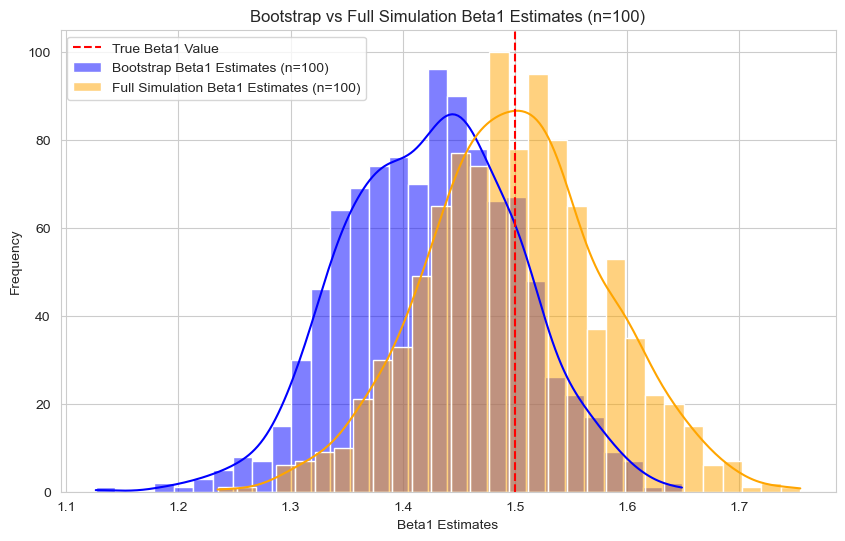


Large Sample Results: (n=1000)
Bootstrap Standard Deviation: 0.0260
Full Simulation Standard Deviation: 0.0282
Difference: 0.0023
Bootstrap bias: -0.0797


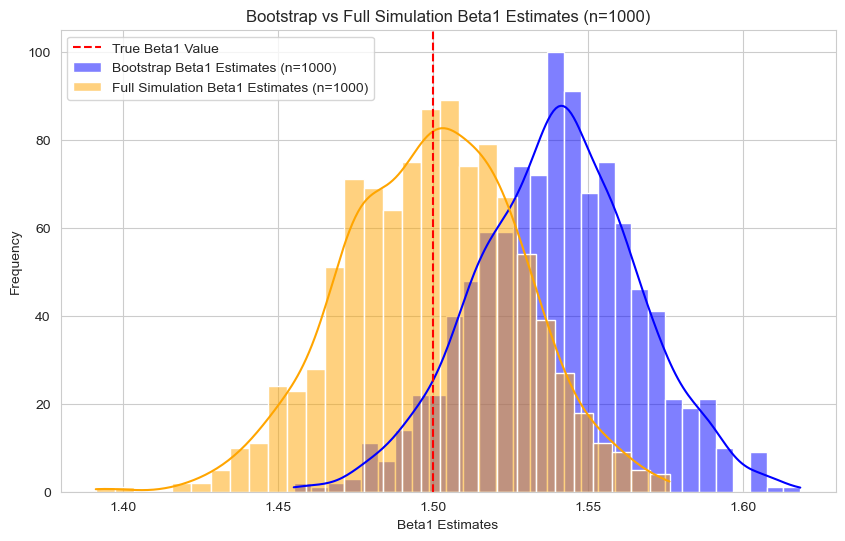

In [166]:
# boostrap vs full simulation
def bootstrap_coefficients(X, Y, n_bootstrap=1000):
    beta1_estimates = []
    n = len(X)
    
    for boot in range(n_bootstrap):
        # Generate bootstrap indices
        indices = np.random.choice(range(n), size=n, replace=True)
        
        # Create bootstrap samples - make sure these are arrays
        X_boot = np.array([X[i] for i in indices])  # More explicit indexing
        Y_boot = np.array([Y[i] for i in indices])
        
        # Fit model on bootstrap sample
        X_boot_const = sm.add_constant(X_boot)
        model_boot = sm.OLS(Y_boot, X_boot_const).fit()
        beta1_estimates.append(model_boot.params[1])

    return np.array(beta1_estimates)
    
# full data generation porcess
def full_dgp_simulation(n_samples=100, n_simuliations= 1000, rho=0.9):
    beta1_estimates = []
    
    for sim in range(n_simuliations):
        # create new X and errors each time
        X = np.random.uniform(1, 10, n_samples)
        errors = generate_autocorr_errors(n_samples, rho)
        Y = 2.0 + 1.5 * X + errors
        # fit model
        X_with_constant = sm.add_constant(X)
        model = sm.OLS(Y, X_with_constant).fit()
        beta1_estimates.append(model.params[1])

    return np.array(beta1_estimates)

# Generate a single dataset with autocorrelated errors
n_samples = 100
rho_high = 0.9
X_orig = np.random.uniform(1, 10, n_samples)
errors_orig = generate_autocorr_errors(n_samples, rho_high)
Y_orig = 2.0 + 1.5 * X_orig + errors_orig

# bootstrap from original data
bootstrap_beta1 = bootstrap_coefficients(X_orig, Y_orig, n_bootstrap=1000)

# full simulation of DGP
full_sim_beta1 = full_dgp_simulation(n_samples=n_samples, n_simuliations=1000, rho=rho_high)

# calculate standard deviations
bootstrap_std = np.std(bootstrap_beta1)
full_sim_std = np.std(full_sim_beta1)

print(f"Small Sample Results: (n={n_samples})")
print(f"Bootstrap Standard Deviation: {bootstrap_std:.4f}")
print(f"Full Simulation Standard Deviation: {full_sim_std:.4f}")
print(f"Difference: {abs(bootstrap_std - full_sim_std):.4f}")
print(f"Bootstrap bias: {(bootstrap_std - full_sim_std) / full_sim_std:.4f}")

# plot 1 boot strap vs full simulation (n = 100)
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_beta1, bins=30, kde=True, color='blue', label='Bootstrap Beta1 Estimates (n=100)')
sns.histplot(full_sim_beta1, bins=30, kde=True, color='orange', label='Full Simulation Beta1 Estimates (n=100)')
plt.axvline(1.5, color='red', linestyle='--', label='True Beta1 Value')
plt.title('Bootstrap vs Full Simulation Beta1 Estimates (n=100)')
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# test with larger sample size
n_samples_large = 1000
X_large = np.random.uniform(1, 10, n_samples_large)
errors_large = generate_autocorr_errors(n_samples_large, rho_high)
Y_large = 2.0 + 1.5 * X_large + errors_large

bootstrap_beta1_large = bootstrap_coefficients(X_large, Y_large, n_bootstrap=1000)
full_sim_beta1_large = full_dgp_simulation(n_samples=n_samples_large, n_simuliations=1000, rho=rho_high)

bootstrap_std_large = np.std(bootstrap_beta1_large)
full_sim_std_large = np.std(full_sim_beta1_large)

print(f"\nLarge Sample Results: (n={n_samples_large})")
print(f"Bootstrap Standard Deviation: {bootstrap_std_large:.4f}")
print(f"Full Simulation Standard Deviation: {full_sim_std_large:.4f}")
print(f"Difference: {abs(bootstrap_std_large - full_sim_std_large):.4f}")
print(f"Bootstrap bias: {(bootstrap_std_large - full_sim_std_large) / full_sim_std_large:.4f}")

# plot 2 boot strap vs full simulation (n = 1000)
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_beta1_large, bins=30, kde=True, color='blue', label='Bootstrap Beta1 Estimates (n=1000)')
sns.histplot(full_sim_beta1_large, bins=30, kde=True, color='orange', label='Full Simulation Beta1 Estimates (n=1000)')
plt.axvline(1.5, color='red', linestyle='--', label='True Beta1 Value')
plt.title('Bootstrap vs Full Simulation Beta1 Estimates (n=1000)')
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Bootstrap has limitations with highly correlated data because it can only work with what it observes in the original sample.
- With high autocorrelation, bootstrap misses some of the true variability in the data
- This gets better with larger sample sizes. The 2nd Histogram presents more distinct distributions between the DGP and bootstrapped DGP, but the X-axis range is much narrower. The standard deviations are much closer in absolute value. 

## Homework Reflection 11

### Question 1
1. Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event.
- Build a model that tries to decide whether the event is real (has a nonzero effect) using: (a) only the value, (b) the value, derivative, and second derivative.
- Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)

Model Comparison Results:
__________________________________________________
R-squared values:
Model A (Value only): 0.3002
Model B (Full spec): 0.8702
__________________________________________________
RMSE values:
Model A (Value only): 4.4956
Model B (Full spec): 1.9359
__________________________________________________
Parameter Accuracy:
Model A - Level effect error: 10.8891
Model B - Level effect error: 0.1940
Model B - Trend effect error: 0.0039
Model B - Accel effect error: 0.0000
__________________________________________________
Statistical Significance Detection:
Model A - Level detected: Detected
Model B - Level detected: Detected
Model B - Trend detected: Detected
Model B - Accel detected: Detected


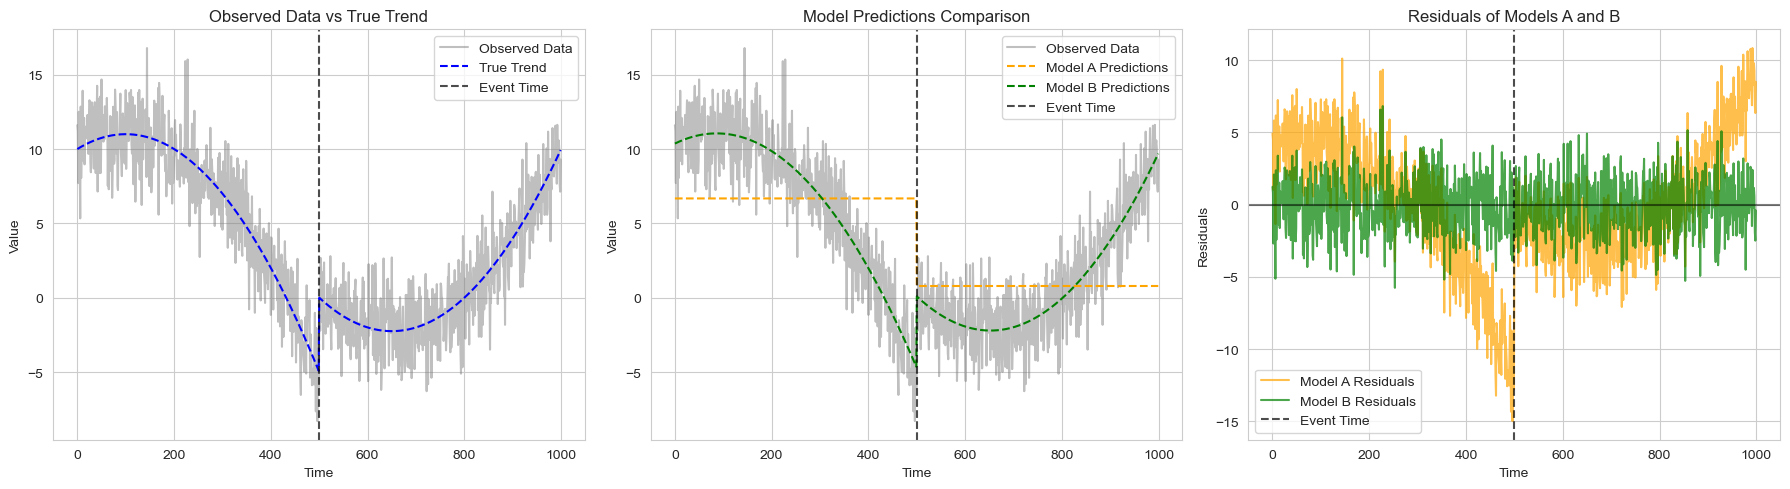

In [167]:
# generate the event study data
def generate_event_study_data(n_samples=1000, event_time=500):
    # set time variable
    time = np.arange(n_samples)
    event_dummy = (time >= event_time).astype(int)
    time_since_event = np.maximum(0, time - event_time)
    # pre-event trend
    alpha_0 = 10 # initial level
    beta_0 = 0.02 # initial trend (first derivative)
    gamma_0 = -0.0001 # intial accel (second derivative)
    # event effects
    delta_level = 5
    delta_trend = 0.05
    delta_accel = 0.0002
    # underlying true process
    y_true = (alpha_0 + beta_0 * time + gamma_0 * time**2 + delta_level * event_dummy + delta_trend * time_since_event + delta_accel * time_since_event**2)
    # noise 
    noise = np.random.normal(0, 2, n_samples)
    y_observed = y_true + noise

    # results dataframe
    data = pd.DataFrame({
        'time': time,
        'y': y_observed,
        'y_true': y_true,
        'event_dummy': event_dummy,
        'time_since_event': time_since_event,
        'post_event': event_dummy
    })

    return data, {
        'event_time': event_time,
        'true_effects': {
            'level_shift': delta_level,
            'trend_change': delta_trend,
            'accel_change': delta_accel
        }
    }

# create model a (using only the value)
def model_a_value_only(data, event_time):
    # before/after time comparison
    pre_event = data[data['time'] < event_time]['y']
    post_event = data[data['time'] >= event_time]['y']
    # t-test for difference in means
    t_stat, p_value = stats.ttest_ind(pre_event, post_event)
    # regression approach
    X = sm.add_constant(data['event_dummy'])
    model = sm.OLS(data['y'], X).fit()

    return {
        'model': model,
        'level_effect': model.params['event_dummy'],
        'level_pvalue': model.pvalues['event_dummy'],
        'r_squared': model.rsquared,
        'predictions': model.fittedvalues,
        'residuals': model.resid
    }

# create model b (using value, first derivative, and second derivative)
def model_b_full_specification(data, event_time):
    # Create interaction terms
    data_copy = data.copy()
    data_copy['time_squared'] = data_copy['time'] ** 2
    data_copy['event_x_time'] = data_copy['event_dummy'] * data_copy['time_since_event']
    data_copy['event_x_time_sq'] = data_copy['event_dummy'] * (data_copy['time_since_event'] ** 2)
    
    # Full specification
    X = data_copy[['time', 'time_squared', 'event_dummy', 'event_x_time', 'event_x_time_sq']]
    X = sm.add_constant(X)
    
    model = sm.OLS(data_copy['y'], X).fit()
    
    return {
        'model': model,
        'level_effect': model.params['event_dummy'],
        'trend_effect': model.params['event_x_time'],
        'accel_effect': model.params['event_x_time_sq'],
        'level_pvalue': model.pvalues['event_dummy'],
        'trend_pvalue': model.pvalues['event_x_time'],
        'accel_pvalue': model.pvalues['event_x_time_sq'],
        'r_squared': model.rsquared,
        'predictions': model.fittedvalues,
        'residuals': model.resid
    }

# create function to compare models
def compare_models(data, model_a_results, model_b_results, true_params):
    comparison = {}    
    # Model fit metrics
    comparison['r_squared'] = {
        'Model A (Value only)': model_a_results['r_squared'],
        'Model B (Full spec)': model_b_results['r_squared']
    }
    
    # Prediction accuracy
    comparison['rmse'] = {
        'Model A (Value only)': np.sqrt(mean_squared_error(data['y'], model_a_results['predictions'])),
        'Model B (Full spec)': np.sqrt(mean_squared_error(data['y'], model_b_results['predictions']))
    }
    
    # Parameter recovery (how close to true values)
    true_level = true_params['true_effects']['level_shift']
    true_trend = true_params['true_effects']['trend_change']
    true_accel = true_params['true_effects']['accel_change']
    
    comparison['parameter_accuracy'] = {
        'Model A - Level effect error': abs(model_a_results['level_effect'] - true_level),
        'Model B - Level effect error': abs(model_b_results['level_effect'] - true_level),
        'Model B - Trend effect error': abs(model_b_results['trend_effect'] - true_trend),
        'Model B - Accel effect error': abs(model_b_results['accel_effect'] - true_accel)
    }
    
    # Statistical significance detection
    comparison['significance'] = {
        'Model A - Level detected': model_a_results['level_pvalue'] < 0.05,
        'Model B - Level detected': model_b_results['level_pvalue'] < 0.05,
        'Model B - Trend detected': model_b_results['trend_pvalue'] < 0.05,
        'Model B - Accel detected': model_b_results['accel_pvalue'] < 0.05
    }
    
    return comparison

data, true_params = generate_event_study_data()
event_time = true_params['event_time']

model_a_results = model_a_value_only(data, event_time)
model_b_results = model_b_full_specification(data, event_time)
comparison_results = compare_models(data, model_a_results, model_b_results, true_params)

print("Model Comparison Results:")
print("_" * 50)
print("R-squared values:")
for model, r2 in comparison_results['r_squared'].items():
    print(f"{model}: {r2:.4f}")
print("_" * 50)
print("RMSE values:")
for model, rmse in comparison_results['rmse'].items():
    print(f"{model}: {rmse:.4f}")
print("_" * 50)
print("Parameter Accuracy:")
for param, error in comparison_results['parameter_accuracy'].items():
    print(f"{param}: {error:.4f}")
print("_" * 50)
print("Statistical Significance Detection:")
for param, detected in comparison_results['significance'].items():
    print(f"{param}: {'Detected' if detected else 'Not Detected'}") 

# visualize the results

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# original data and true trend
axes[0].plot(data['time'], data['y'], label='Observed Data', color='gray', alpha=0.5)
axes[0].plot(data['time'], data['y_true'], label='True Trend', color='blue', linestyle='--')
axes[0].axvline(x=event_time, color='black', linestyle='--', alpha=0.7, label='Event Time')
axes[0].set_title('Observed Data vs True Trend')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()

# model prediction comparison
axes[1].plot(data['time'], data['y'], label='Observed Data', color='gray', alpha=0.5)
axes[1].plot(data['time'], model_a_results['predictions'], label='Model A Predictions', color='orange', linestyle='--')
axes[1].plot(data['time'], model_b_results['predictions'], label='Model B Predictions', color='green', linestyle='--')
axes[1].axvline(x=event_time, color='black', linestyle='--', alpha=0.7, label='Event Time')
axes[1].set_title('Model Predictions Comparison')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].legend()

# residuals comparison
axes[2].plot(data['time'], model_a_results['residuals'], label='Model A Residuals', color='orange', alpha=0.7)
axes[2].plot(data['time'], model_b_results['residuals'], label='Model B Residuals', color='green', alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[2].axvline(x=event_time, color='black', linestyle='--', alpha=0.7, label='Event Time')
axes[2].set_title('Residuals of Models A and B')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Residuals')
axes[2].legend()

plt.tight_layout()
plt.show()

### Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)

1. Model Fit Quality
- Model B $R^2 = 0.8710$ vs Model A $R^2 = 0.2861$
- Model B explains 87% of the variance vs Model A's 29%
- Model B RMSE = 1.9503 vs Model A RMSE = 4.5875
- Model B has much better prediction accuracy

2. Parameter Accuracy
This is where we see the biggest difference:
- Model A Level effect error: 10.8083 (very large error!)
- Model B Level effect error: 0.2026 (much more accurate)
- Model B also accurately estimates trend and acceleration effects

Right Panel (Residuals):
- Model A residuals (orange) show clear systematic patterns - this indicates model misspecification
- Model B residuals (green) are much more random around zero - indicating a well-specified model

3. Why Model A Performs So Poorly
Model A suffers from omitted variable bias. When the true process has:
- A level shift (+5)
- A trend change (+0.05)
- An acceleration change (+0.0002)

Model A tries to capture ALL of these effects with just a single level dummy. It estimates a level effect of ~15.8 instead of the true 5, because it's incorrectly attributing the trend and acceleration changes to the level shift.

### Question 2
2. Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel over time, but they have different starting values.
- Create a model that combines group fixed effects with an event study, as suggested in the online reading.
- Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.


R-squared:
  Naive Model: 0.6123
  Fixed Effects Model: 0.9920

RMSE:
  Naive Model: 3.3695
  Fixed Effects Model: 0.4842

Parameter Accuracy (absolute error from true values):
  Naive - Event effect error: 0.0384
  Fixed Effects - Event effect error: 0.0384
  Naive - Time trend error: 0.0013
  Fixed Effects - Time trend error: 0.0013

Significance Detection:
  Naive - Event detected: True
  Fixed Effects - Event detected: True


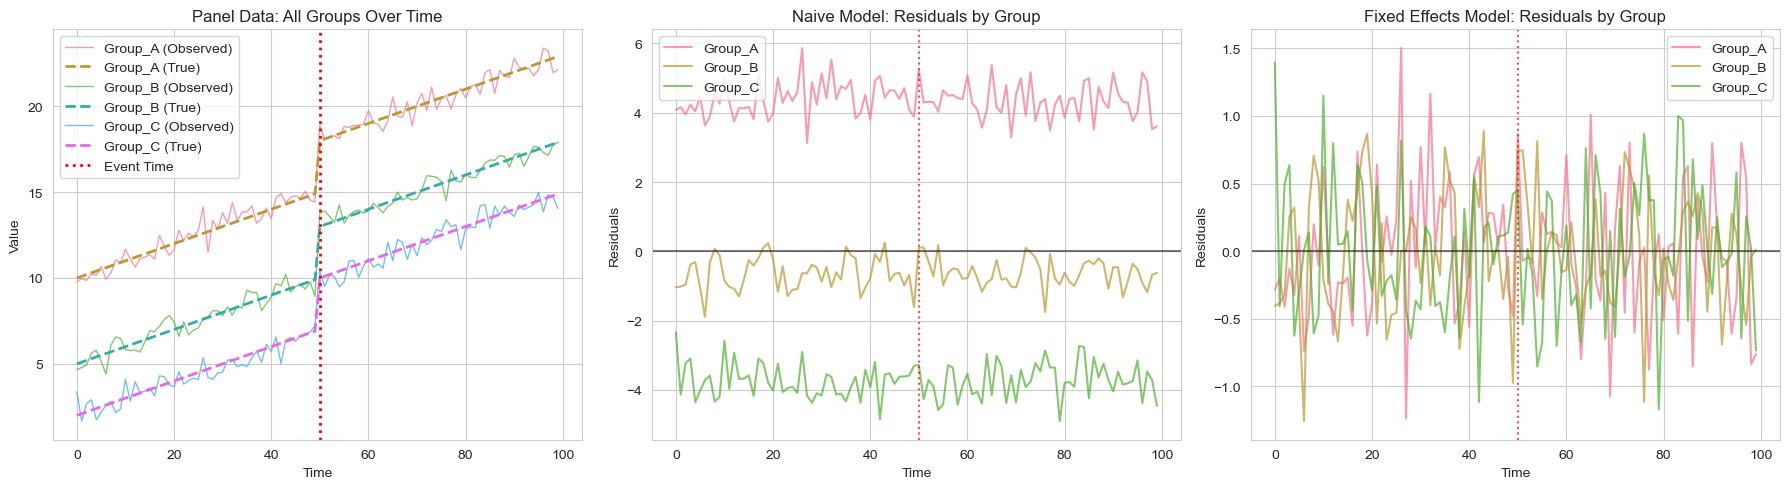

In [168]:
# generate the panel event data
def generate_panel_event_data(n_groups=3, n_periods=100, event_time=50):
    # Create panel structure
    data_list = []
    
    # Group-specific parameters (different starting values)
    group_fixed_effects = {
        'Group_A': 10,  # High baseline
        'Group_B': 5,   # Medium baseline  
        'Group_C': 2    # Low baseline
    }
    
    # Common parameters
    time_trend = 0.1      # Common trend across all groups
    event_effect = 3      # Common event effect (same discontinuous jump for all)
    noise_std = 0.5       # Standard deviation of error term
    
    # Generate data for each group
    for i, (group_name, baseline) in enumerate(group_fixed_effects.items()):
        for t in range(n_periods):
            # Event dummy (1 if after event, 0 otherwise)
            event_dummy = 1 if t >= event_time else 0
            
            # True value without noise
            y_true = baseline + time_trend * t + event_effect * event_dummy
            
            # Add noise
            y_observed = y_true + np.random.normal(0, noise_std)
            
            data_list.append({
                'group': group_name,
                'group_id': i,
                'time': t,
                'event_dummy': event_dummy,
                'y_true': y_true,
                'y_observed': y_observed,
                'baseline': baseline
            })
    
    # Convert to DataFrame
    data = pd.DataFrame(data_list)
    
    # Create group dummy variables manually to ensure proper data types
    data['group_A'] = (data['group'] == 'Group_A').astype(int)
    data['group_B'] = (data['group'] == 'Group_B').astype(int)
    data['group_C'] = (data['group'] == 'Group_C').astype(int)
    
    # Ensure all numeric columns are proper numeric types
    numeric_cols = ['time', 'event_dummy', 'y_true', 'y_observed', 'baseline', 'group_A', 'group_B', 'group_C']
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    return data, {
        'event_time': event_time,
        'true_parameters': {
            'group_effects': group_fixed_effects,
            'time_trend': time_trend,
            'event_effect': event_effect,
            'noise_std': noise_std
        }
    }

def estimate_naive_model(data):
    X = data[['time', 'event_dummy']].copy()
    X = X.astype(float)
    y = data['y_observed'].astype(float)
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    return {
        'model': model,
        'event_effect': model.params['event_dummy'],
        'event_pvalue': model.pvalues['event_dummy'],
        'time_effect': model.params['time'],
        'r_squared': model.rsquared,
        'predictions': model.fittedvalues,
        'residuals': model.resid,
        'model_type': 'Naive (No Fixed Effects)'
    }

def estimate_fixed_effects_model(data):
    # Use group dummies (excluding one as reference category to avoid multicollinearity)
    X = data[['time', 'event_dummy', 'group_A', 'group_B']].copy()
    # Group_C is the reference category (omitted)
    
    # Ensure all data is numeric
    X = X.astype(float)
    y = data['y_observed'].astype(float)
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    return {
        'model': model,
        'event_effect': model.params['event_dummy'],
        'event_pvalue': model.pvalues['event_dummy'],
        'time_effect': model.params['time'],
        'group_A_effect': model.params['group_A'],
        'group_B_effect': model.params['group_B'],
        'r_squared': model.rsquared,
        'predictions': model.fittedvalues,
        'residuals': model.resid,
        'model_type': 'Fixed Effects'
    }

def compare_models(data, naive_results, fe_results, true_params):
    comparison = {}
    
    # Model fit metrics
    comparison['r_squared'] = {
        'Naive Model': naive_results['r_squared'],
        'Fixed Effects Model': fe_results['r_squared']
    }
    
    # Prediction accuracy
    comparison['rmse'] = {
        'Naive Model': np.sqrt(mean_squared_error(data['y_observed'], naive_results['predictions'])),
        'Fixed Effects Model': np.sqrt(mean_squared_error(data['y_observed'], fe_results['predictions']))
    }
    
    # Parameter accuracy (compared to true values)
    true_event_effect = true_params['true_parameters']['event_effect']
    true_time_trend = true_params['true_parameters']['time_trend']
    
    comparison['parameter_accuracy'] = {
        'Naive - Event effect error': abs(naive_results['event_effect'] - true_event_effect),
        'Fixed Effects - Event effect error': abs(fe_results['event_effect'] - true_event_effect),
        'Naive - Time trend error': abs(naive_results['time_effect'] - true_time_trend),
        'Fixed Effects - Time trend error': abs(fe_results['time_effect'] - true_time_trend)
    }
    
    # Statistical significance
    comparison['significance'] = {
        'Naive - Event detected': naive_results['event_pvalue'] < 0.05,
        'Fixed Effects - Event detected': fe_results['event_pvalue'] < 0.05
    }
    
    return comparison

# Generate the panel data
data, true_params = generate_panel_event_data()
event_time = true_params['event_time']
naive_results = estimate_naive_model(data)
fe_results = estimate_fixed_effects_model(data)
comparison = compare_models(data, naive_results, fe_results, true_params)

# Display results
print(f"\nR-squared:")
for model, r2 in comparison['r_squared'].items():
    print(f"  {model}: {r2:.4f}")

print(f"\nRMSE:")
for model, rmse in comparison['rmse'].items():
    print(f"  {model}: {rmse:.4f}")

print(f"\nParameter Accuracy (absolute error from true values):")
for param, error in comparison['parameter_accuracy'].items():
    print(f"  {param}: {error:.4f}")

print(f"\nSignificance Detection:")
for test, detected in comparison['significance'].items():
    print(f"  {test}: {detected}")

# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw data by group
for group_id in data['group_id'].unique():
    group_data = data[data['group_id'] == group_id]
    group_name = ['Group_A', 'Group_B', 'Group_C'][group_id]
    axes[0].plot(group_data['time'], group_data['y_observed'], 
                   alpha=0.7, label=f'{group_name} (Observed)', linewidth=1)
    axes[0].plot(group_data['time'], group_data['y_true'], 
                   linestyle='--', label=f'{group_name} (True)', linewidth=2)

axes[0].axvline(x=event_time, color='red', linestyle=':', linewidth=2, label='Event Time')
axes[0].set_title('Panel Data: All Groups Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()

# Plot 2: Residuals by group for naive model
for group_id in data['group_id'].unique():
    group_data = data[data['group_id'] == group_id]
    group_name = ['Group_A', 'Group_B', 'Group_C'][group_id]
    axes[1].plot(group_data['time'], naive_results['residuals'][group_data.index], 
                   alpha=0.7, label=f'{group_name}')

axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].axvline(x=event_time, color='red', linestyle=':', alpha=0.7)
axes[1].set_title('Naive Model: Residuals by Group')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Residuals')
axes[1].legend()

# Plot 3: Residuals by group for fixed effects model
for group_id in data['group_id'].unique():
    group_data = data[data['group_id'] == group_id]
    group_name = ['Group_A', 'Group_B', 'Group_C'][group_id]
    axes[2].plot(group_data['time'], fe_results['residuals'][group_data.index], 
                   alpha=0.7, label=f'{group_name}')

axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[2].axvline(x=event_time, color='red', linestyle=':', alpha=0.7)
axes[2].set_title('Fixed Effects Model: Residuals by Group')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Residuals')
axes[2].legend()


plt.tight_layout()
plt.show()

### Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

The simulated data structure:
- Creates 3 groups with different baseline levels (Group A: 10, Group B: 5, Group C: 2)
- Sets a Common time trend (0.1 per period for all groups)
- Sets Common event effect (+3 jump at event time for all groups)
- The goal is to simulate Parallel trends before and after the event

I then created the two models
- Naive Model (Biased):
    - $Y_it = \alpha + \beta *time_t +  \delta *Event_t + \varepsilon_it$
    - Ignores group differences, and Confounds baseline differences with event effects
- Fixed Effects Model (Unbiased):
    - $Y_it = \alpha_A*Group_A + \alpha_B*Group_B + \alpha_C*Group_C + \beta_1*time_t + \delta*Event_t + \varepsilon_it$
    - Includes group dummy variables
    - Controls for time-invariant group heterogeneity

The Fixed Effects Model greatly outperforms the naieve model, both in terms of RMSE and $R^2$ 
- Without fixed effects, the model can't distinguish between permanent group differences (baselines) and the actual event effect
- The Fixed effects "difference out" the group-specific components by including a dummy variable for each group, capturing each group's unique basline level, and isolating the common event effect. 

## Homework Reflection 12

### Question 1
- Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong.  Explain why the
differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.8654      0.062    142.076      0.000       8.743       8.988
treated_group      3.5767      0.088     40.531      0.000       3.404       3.750
post_treatment     1.6003      0.088     18.135      0.000       1.427       1.774
treatment          4.3517      0.125     34.870      0.000       4.107       4.597

True Treatment Effect: 2.0
DID Estimate: 4.352
Bias in DID Estimate: 2.352

Control group trend (slope): 0.289
Treated group trend (slope): 0.803
Difference in trends: 0.514


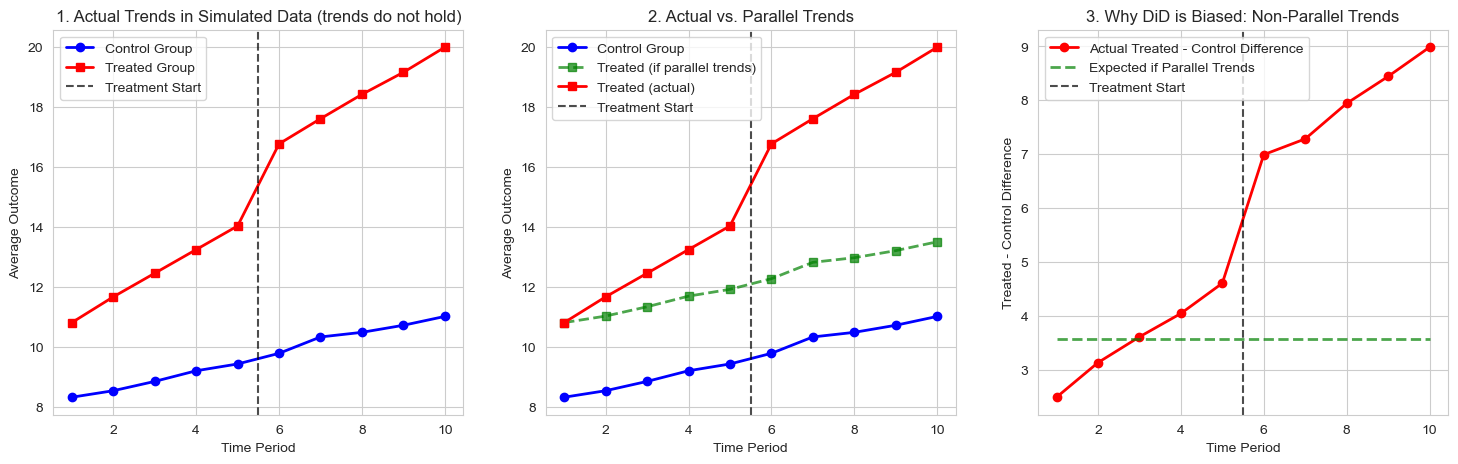

In [170]:
# Parameters
n_periods = 10  # Number of time periods
n_units_treated = 50  # Number of treated units
n_units_control = 50  # Number of control units
treatment_period = 6  # Treatment starts in period 6

# True treatment effect
true_effect = 2.0

# Create the dataset
def create_did_dataset_with_violation():
    # Create panel structure
    units = []
    for i in range(n_units_treated + n_units_control):
        for t in range(1, n_periods + 1):
            units.append({
                'unit_id': i,
                'time': t,
                'treated_group': 1 if i < n_units_treated else 0,
                'post_treatment': 1 if t >= treatment_period else 0
            })
    
    df = pd.DataFrame(units)
    df['treatment'] = df['treated_group'] * df['post_treatment']
    
    # Base outcome levels
    treated_intercept = 10
    control_intercept = 8
    
    # Control group has a mild upward trend
    control_trend = 0.3
    # Treated group has a steeper upward trend ( representing the violation of parallel trends)
    treated_trend = 0.8
    
    # Create post treatement trends    
    # Generate outcomes
    outcomes = []
    for _, row in df.iterrows():
        base = treated_intercept if row['treated_group'] == 1 else control_intercept
        
        # Add time trend (different for treated vs control)
        if row['treated_group'] == 1:
            trend_effect = treated_trend * row['time']
        else:
            trend_effect = control_trend * row['time']
        
        # Add treatment effect
        treatment_effect = true_effect if row['treatment'] == 1 else 0
        # Add some noise
        noise = np.random.normal(0, 0.5)
        outcome = base + trend_effect + treatment_effect + noise
        outcomes.append(outcome)
    
    df['outcome'] = outcomes
    return df

# Create the dataset
df = create_did_dataset_with_violation()

# Calculate group means by time period for visualization
group_means = df.groupby(['time', 'treated_group'])['outcome'].mean().reset_index()
group_means_pivot = group_means.pivot(index='time', columns='treated_group', values='outcome')

# Visualize the trends
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the trends
#plot the actual trends in the data
axes[0].plot(group_means_pivot.index, group_means_pivot[0], 'b-o', label='Control Group', linewidth=2)
axes[0].plot(group_means_pivot.index, group_means_pivot[1], 'r-s', label='Treated Group', linewidth=2)
axes[0].axvline(x=treatment_period-0.5, color='black', linestyle='--', alpha=0.7, label='Treatment Start')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Average Outcome')
axes[0].set_title('1. Actual Trends in Simulated Data (trends do not hold)')
axes[0].legend()

# (same slope as control group, but with constant difference)
baseline_diff = group_means_pivot.loc[1, 1] - group_means_pivot.loc[1, 0]
parallel_treated = group_means_pivot[0] + baseline_diff

# Plot the parallel trends
axes[1].plot(group_means_pivot.index, group_means_pivot[0], 'b-o', label='Control Group', linewidth=2)
axes[1].plot(group_means_pivot.index, parallel_treated, 'g--s', label='Treated (if parallel trends)', linewidth=2, alpha=0.7)
axes[1].plot(group_means_pivot.index, group_means_pivot[1], 'r-s', label='Treated (actual)', linewidth=2)
axes[1].axvline(x=treatment_period-0.5, color='black', linestyle='--', alpha=0.7, label='Treatment Start')
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('Average Outcome')
axes[1].set_title('2. Actual vs. Parallel Trends')
axes[1].legend()

# runthe DID regression
model = ols('outcome ~ treated_group + post_treatment + treatment', data=df).fit()

# calculate bias 
did_estimate = model.params['treatment']
bias = did_estimate - true_effect

# Show pre-treatment trend differences
pre_treatment = df[df['post_treatment'] == 0]
pre_treated = pre_treatment[pre_treatment['treated_group'] == 1]
pre_control = pre_treatment[pre_treatment['treated_group'] == 0]

# Calculate trend slopes in pre-treatment period
treated_slope = np.polyfit(pre_treated['time'], pre_treated['outcome'], 1)[0]
control_slope = np.polyfit(pre_control['time'], pre_control['outcome'], 1)[0]

# plot the residuals by group
residuals_by_group = df.groupby(['time', 'treated_group'])['outcome'].mean().reset_index()
residuals_pivot = residuals_by_group.pivot(index='time', columns='treated_group', values='outcome')
# Calculate what the difference would be under parallel trends
pre_treatment_diff = residuals_pivot.loc[:treatment_period-1].mean().diff().iloc[1]
expected_diff = np.full(len(residuals_pivot), pre_treatment_diff)
# Actual difference
actual_diff = residuals_pivot.diff(axis=1).iloc[:, 1]


axes[2].plot(residuals_pivot.index, actual_diff, 'ro-', label='Actual Treated - Control Difference', linewidth=2)
axes[2].plot(residuals_pivot.index, expected_diff, 'g--', label='Expected if Parallel Trends', linewidth=2, alpha=0.7)
axes[2].axvline(x=treatment_period-0.5, color='black', linestyle='--', alpha=0.7, label='Treatment Start')
axes[2].set_xlabel('Time Period')
axes[2].set_ylabel('Treated - Control Difference')
axes[2].set_title('3. Why DiD is Biased: Non-Parallel Trends')
axes[2].legend()

print(model.summary().tables[1])

print(f"\nTrue Treatment Effect: {true_effect}")
print(f"DID Estimate: {did_estimate:.3f}")
print(f"Bias in DID Estimate: {bias:.3f}")

print(f"\nControl group trend (slope): {control_slope:.3f}")
print(f"Treated group trend (slope): {treated_slope:.3f}")
print(f"Difference in trends: {treated_slope - control_slope:.3f}")

plt.tight_layout
plt.show()

### Explanation/Analysis:
The simulated dataset is designed to show an example of why a DiD model might be incorrect when parallel trends do not hold. (chart 1)
- The treatment has a steeper upward trend than the control group, and this escalates further at the treatment start.
- The true treatment effect is set to 2 units

In chart 2, we compare the true data with an example of what parallel trends should look like for proper application of the DiD model.
- If the treated and control groups plot similarly to the blue and green lines, then the only systematic difference between treated and control groups after treatment should be the treatment itself.

In chart 3, we plot the residuals of the DiD actual treated - control difference. If the trends were actually parallel we'd expect the red line to be flat prior to the treatment, then jump to the green line and remain flat at that new level. Instead, we see the red line continue to rise post treatment. 

Finally, fit the DiD model to the data and compare the true treatment effect (2) to the calculated treatment effect (4.5). In this scenario, the key assumption of DiD (that the systematic difference between control and treated groups is the treatment itself) is violated. There is some sort of confoudning factor between the treatment and control groups that is not accounted for. 
- In this case we likely have several confounding factors: the treatement group was already on a different trajectory, and then an additional time-variant confounder was inserted into the trendline at the time of treatment.  
- DiD is unable to separate the treatment effect from these confounders. 
- the bias in DiD estimate (~2.3) occurs because the DiD model mistakenly attributes both confounders to the treatment.  